# Chapter 8 - Model Inference and Averaging

### Section 8.1 - Introduction
* Fitting of models up to this point has been by least squares or minimising cross-entropy for classification. Both of these are instances of maximum likelihood approach.
* In this chapter, we go over the maximum likelihood approach as well as the Bayesian method for inference.

### Section 8.2 - The Bootstrap and Maximum Likelihood Methods

* Non-parameteric bootstrap -- what we discussed in Chapter 7. New datasets are generated without a specific parametric model. They are "model free".
* Parametric bootstrap -- simulates new responses by adding Gaussian noise to the predicted values.
* Likelihood function -- probability of the observed data under the model specificied by $g_\theta$, the probability density function:  $L(\theta; Z) = \prod_{i=1}^{N} g_{\theta}(z_i)$.
* Maximum likelihood function seeks to maximimize the log of the function $L$ by picking the best $\theta$ given fixed data, $Z$.
* The score function is defined as the partial derivative of the log-likelihood function evaluated at $\theta$ and $Z$. The information matrix, $I(\theta)$ is the negative of the second partial derivative.
* The expected value of $I(\theta)$ is the Fisher information.
* Computing the maximum likelihood uses standard calculus for maximizing functions.

### Section 8.3 - Bayesian Methods

* In Bayesian approach, we specific a sampling density function $Pr(Z|\theta)$ for our data given the parameters. 
* We also specify a prior distribution $Pr(\theta)$ reflecting our knowledge about $\theta$ before we see the data.
* Next, we compute the posterior distribution $Pr(\theta|Z) = \frac{Pr(Z|\theta)Pr(\theta)}{\int Pr(Z|\theta)Pr(\theta) d\theta}$. This represents our knowledge about $\theta$ after we see the data.
* This gives you a probability distribution for what $\theta$ is,  given our data.

### Section 8.4 - Relationship Between the Bootstrap and Bayesian Inference

* The bootstrap distribution represents an approximate, nonparametric, noninformative, posterior distribution for our parameter $\theta$.
* The advantage of the bootstrap is that we did not have to formally specify a prior, nor sample from the posterior -- it is a 'poor mans' Bayes posterior.
* By perturbing the data (parametric bootstrap), the bootstrap approximates the Bayesian effect of perturbing the parameters.

### Section 8.5 - The EM Algorithm

* Tool for simplifying difficult maximum likelihood problems (e.g. Gaussian mixture).
* An expectation–maximization (EM) algorithm is an iterative method to find maximum likelihood or maximum a posteriori (MAP) estimates of parameters in statistical models, where the model depends on unobserved latent variables.
* Latent variables are variables that are not directly observed but are rather inferred.
* One can simply pick arbitrary values for one of the two sets of unknowns, use them to estimate the second set, then use these new values to find a better estimate of the first set, and then keep alternating between the two until the resulting values both converge to fixed points.
* The EM iteration alternates between performing an expectation (E) step, which creates a function for the expectation of the log-likelihood evaluated using the current estimate for the parameters, and a maximization (M) step, which computes parameters maximizing the expected log-likelihood found on the E step. These parameter-estimates are then used to determine the distribution of the latent variables in the next E step.

In [1]:
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
X,y = load_diabetes(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=10)

In [2]:
# sklearn Gaussian Mixture uses EM algorithm to fit
from sklearn.mixture import GaussianMixture
import numpy as np

gm = GaussianMixture(n_components=2, covariance_type='full', tol=0.001, reg_covar=1e-06, max_iter=100, n_init=1, 
                     init_params='kmeans', weights_init=None, means_init=None, precisions_init=None, 
                     random_state=None, warm_start=False, verbose=0, verbose_interval=10)

# Train the model using the training sets
gm.fit(X_train, y_train)

# Predict and compute RSS on test set
predictions_test = gm.predict(X_test)
rss = np.mean((predictions_test - y_test) ** 2)
print('RSS: {}'.format(rss))
print('Mixture weight 1: {}'.format(gm.weights_[0]))
print('Mixture weight 2: {}'.format(gm.weights_[1]))

RSS: 28682.72602739726
Mixture weight 1: 0.6761650172754295
Mixture weight 2: 0.3238349827245701


### Section 8.6 - MCMC for Sampling from the Posterior

* We often want to draw samples from the posterior Bayesian in order to perform inference on the parameters.
* Gibbs sampling, an MCMC (Markov Chain Monte Carlo) procedure, is closely related to the EM algorithm. The main difference is that it samples from the conditional distributions instead of maximizing over them.
* Suppose we have random variables $U_1, U_2, \dots, U_K$ and we wish to draw a sample from their joint distribution. Suppose this is difficult to do but it is easy to simulate from the conditional distributions $Pr(U_j | U_1, U_2, ... U_{j-1}, U_{j+1}, \dots, U_k)$.  Gibbs sampling alternatively simulates from each of these distributions until the process stabilizes.  Once stabilized, it provides a sample from the desired joint distribution.
* The samples are not independent for different $t$.
* Gibbs sampling produces a Markov chain whose stationary distribution is the true joint distribution.
* Gibbs sampling is just one of a number of recently developed procedures for sampling from posterior distributions. It uses conditional sampling of each parameter given the rest, and is useful when the structure of the problem makes this sampling easy to carry out. Other methods do not require such structure, for example the Metropolis–Hastings algorithm.
* As with other MCMC algorithms, Gibbs sampling generates a Markov chain of samples, each of which is correlated with nearby samples. As a result, care must be taken if independent samples are desired (typically by thinning the resulting chain of samples by only taking every nth value, e.g. every 100th value). In addition, samples from the beginning of the chain (the burn-in period) may not accurately represent the desired distribution.


In [3]:
import numpy as np
import pymc3 as pm
import theano.tensor as tt


def build_model():
    # data
    failure = np.array([0., 1.])
    value = np.array([1., 0.])
    
    # Custom log-likelihood
    def logp(failure, value):
        return tt.sum(failure * tt.log(lam) - lam * value)
    
    # Model is an exponential distribution
    with pm.Model() as model:
        lam = pm.Exponential('lambda', 1.)
        pm.DensityDist('x', logp, observed={'failure': failure, 'value': value})
    return model

def run(n_samples=3000):
    model = build_model()
    
    with model:
        trace = pm.sample(n_samples)
        
    return trace

trace = run()

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lambda]
Sampling 4 chains, 0 divergences: 100%|██████████| 14000/14000 [00:02<00:00, 5589.16draws/s]


Text(0.5, 0, 'lambda')

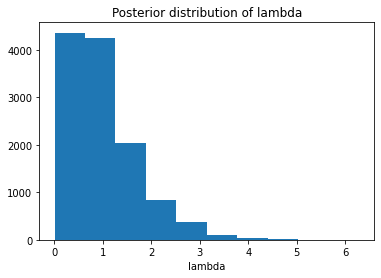

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.hist(trace.get_values('lambda'))
plt.title('Posterior distribution of lambda')
plt.xlabel('lambda')

### Section 8.7 - Bagging

* Bagging = bootstrap aggregation.  
* Bootstrap is a way of assessing the accuracy of a parameter estimate or a prediction, but can also be used to improve the prediction itself. 
* In Section 8.4 we investigated the relationship between the bootstrap and Bayes approaches, and found that the bootstrap mean is approximately a posterior average. Bagging further exploits this connection.
* The bagged estimate is produced by averaging the original predicted value across all bootstramp samples.
* For classification, we can understand the bagging effect in terms of a consensus of independent weak learners.
* Random forests improve on bagging by reducing the correlation between the sampled trees.  More independence between trees = better.
* When we bag a model, any simple structure in the model is lost. As an example, a bagged tree is no longer a tree. For interpretation of the model this is clearly a drawback.

In [6]:
# Similar to bootstrap example from Chapter 7
from sklearn.utils import resample
from sklearn.datasets import load_boston
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas

boston = load_boston()
X = boston.data
y = boston.target
df = pandas.DataFrame(boston.data, columns=boston.feature_names)

B = 10
all_predictions = []

for i in range(B):
    X_bootstrap, y_bootstrap = resample(X, y)
    
    knn = KNeighborsRegressor(n_neighbors=50, weights='uniform', algorithm='auto', leaf_size=30, p=2, 
                          metric='minkowski', metric_params=None, n_jobs=-1)
    
    knn.fit(X_bootstrap, y_bootstrap)
    predictions = knn.predict(X)
    e = mean_squared_error(y, predictions)
    all_predictions.append(predictions)
    
    df['bootstrap{}'.format(i)] = predictions
    
    print('Sample: {} \n MSE: {}, Variance: {}\n'.format(
        i+1,
        e,
        predictions.var(),
    ))

Sample: 1 
 MSE: 58.42873437154151, Variance: 21.410614829977032

Sample: 2 
 MSE: 57.914211652173904, Variance: 17.644707574872285

Sample: 3 
 MSE: 57.73812079841897, Variance: 22.463031214751048

Sample: 4 
 MSE: 58.22995380237154, Variance: 26.464593412051432

Sample: 5 
 MSE: 59.82179012648221, Variance: 23.82376567927948

Sample: 6 
 MSE: 57.553727976284584, Variance: 19.735853019934698

Sample: 7 
 MSE: 57.74765652173913, Variance: 19.664247502319988

Sample: 8 
 MSE: 60.537175525691694, Variance: 14.479234291740223

Sample: 9 
 MSE: 58.200603154150194, Variance: 17.47038681880673

Sample: 10 
 MSE: 56.85766235573122, Variance: 25.435749326375976



In [7]:
# Average all predictions
df['bagged_estimate'] = np.array(all_predictions).mean(axis=0)
df[[c for c in df.columns if 'bootstrap' in c or c == 'bagged_estimate']]

,bootstrap0,bootstrap1,bootstrap2,bootstrap3,bootstrap4,bootstrap5,bootstrap6,bootstrap7,bootstrap8,bootstrap9,bagged_estimate
0,24.000,23.854,24.032,25.838,23.104,26.328,23.542,24.066,23.326,23.480,24.1570
1,27.028,26.970,27.396,28.332,26.544,27.500,27.202,27.090,26.212,29.808,27.4082
2,24.838,25.562,28.922,25.820,24.958,25.708,25.130,26.290,25.618,27.336,26.0182
3,26.208,27.870,30.368,28.858,27.216,27.902,25.810,27.040,27.794,28.464,27.7530
4,26.522,27.998,30.088,28.766,27.256,28.358,25.730,26.998,27.562,28.940,27.8218
...,...,...,...,...,...,...,...,...,...,...,...
501,25.858,24.450,23.192,24.448,24.460,25.630,24.870,23.012,24.582,27.308,24.7810
502,24.914,23.708,24.502,24.936,26.050,26.576,24.526,24.678,24.546,27.934,25.2370
503,25.100,24.910,25.642,25.962,25.798,26.956,24.698,22.834,25.034,27.874,25.4808
504,25.100,24.828,25.718,26.058,26.808,26.956,24.698,23.018,25.498,27.924,25.6606


### Section 8.8 - Model Averaging and Stacking

* Averaging the output of multiple model forms.
* Committee methods take a simple unweighted average of the predictions from each model.
* Weighting by BIC is another more ambitious option. Other non-equal weighting schemes also exist.
* Stacked generalization (stacking) takes into account the complexity of the model when weighting the predictions.
* Stacking works by fitting a least squares regression on $y_i$ as a function of the model predictions to determine the weighting.

### Section 8.9 - Stochastic Search: Bumping

* Bumping uses bootstrap sampling to move randomly through model space. This can help a fitting method avoid getting stuck in a local minima.
* As in bagging, we draw bootstrap samples and fit a model to each. But rather than average the predictions, we choose the model estimated from a bootstrap sample that best fits the training data. We choose the model that produces the smallest prediction error, averaged over the original training set. 
* By perturbing the data, bumping tries to move the fitting procedure around to good areas of model space. For example, if a few data points are causing the procedure to find a poor solution, any bootstrap sample that omits those data points should procedure a better solution.